In [1]:
import geopandas as gp
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import pandas as pd
import numpy as np
from pprint import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px #if using plotly
import folium
import warnings
import uuid
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', None)  # display all columns
pd.options.display.float_format = '{:20,.2f}'.format  # suppress scientific notation

### RQ #2) Which specific flares are the most impactful? 

### RQ #3) Which specific block grous are being most impacted? 


Exploratory question; no hypothesis testing

EJ index = (The Environmental Indicator Percentile for Block Group) x (Demographic Index for Block Group)
  
a) Determine flaring impact metric. 

Something like: buffer_population x EJ Index x flare volume  

b) Calculate impact per flare  

c) Visualize top_x flares by impact  


### Read in files

In [3]:
#ca_state = gp.read_file("data/CA_State_TIGER2016.shp")  # CA state
ca_counties = gp.read_file("data/CA_Counties_TIGER2016.shp")  # CA counties
ca_counties.rename(columns={'NAMELSAD':'cnty_name'}, inplace=True)  # old:new. Match col names for merging

In [4]:
#ca_bg = gp.read_file("data/ca_bg_clean.shp")  # CA block groups, cleaned
# CA block groups merged with EJscreen data
ca_bg_joined = gp.read_file("data/ca_bg_joined_clean.shp")

# update col name for correct area b/c it gets saved as a truncated version when saved as a shapefile out of the 
# main data cleaning notebook
ca_bg_joined.rename(columns={'shape_ar_1':'bg_area'}, inplace=True)  # old:new.
ca_bg_joined.rename(columns={'CNTY_NAME':'cnty_name'}, inplace=True)  # old:new.
print(f'BGs found: {len(ca_bg_joined)}')

BGs found: 25607


In [5]:
# just CA flares
ca_flares = gp.read_file("data/ca_flares_clean.shp")

# renaming 
ca_flares.rename(columns={'NAMELSAD':'cnty_name'}, inplace=True)  # old:new. Match col names for merging

print(f'Flares found: {len(ca_flares)}')

Flares found: 117


In [6]:
# set common crs for project
# epsg3310: https://epsg.io/3310-1739
# units: meters
meters_crs = 3310  # Projected crs. this should be good for this overlay() calculation and all of project. 

ca_counties = ca_counties.to_crs(meters_crs)
ca_flares = ca_flares.to_crs(meters_crs)
ca_bg_joined = ca_bg_joined.to_crs(meters_crs)

### Update ca_flares df

In [7]:
# set col list for BCM_avg calculation
bcm_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

# add new column for average BCM across all years
ca_flares['BCM_avg'] = ca_flares[bcm_list].mean(axis=1) 

In [8]:
# subset to only columns needed for Tableau
col_list = ['flare_id','flare_cate','cnty_name','BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021','BCM_avg', 'geometry']

subset = ca_flares[col_list].copy()

# assign the subsetted copy back to the original variable name to keep total # of df names small 
# throughout project
ca_flares = subset

### Update ca_bg_joined df

In [9]:
# There are five BGs that seem to just be aquatic buffers around the actual county land.
# Dropping them for now 
# Explore if needed: ca_bg_joined.explore()

ids_to_drop = [60839900000, 61119901000, 60379902000, 60379903000, 60599901000]

# Drop the rows with those IDs
ca_bg_joined = ca_bg_joined[~ca_bg_joined['bg_id'].isin(ids_to_drop)]

In [10]:
# subset to only cols needed
subset = ca_bg_joined[['bg_id', 'cnty_name', 'ACSTOTPOP', 'MINORPOP',
                           'D_PM25_2', 'bg_area', 'geometry']].copy()

# assign the subsetted copy back to the original variable name
ca_bg_joined = subset

ca_bg_joined.rename(columns={'geometry':'bg_geom'}, inplace=True)  # old:new. Match col names for merging

In [11]:
# counties_sub = ca_counties[['cnty_name', 'geometry']].copy()

# counties_sub.rename(columns={'geometry':'cnty_geom'}, inplace=True)  # old:new. Match col names for merging

# # add county names to social dataframe
# ca_bg_joined_sub = pd.merge(ca_bg_joined_sub, counties_sub, 
#                              on='cnty_name', how='left')

## Create "baseline" df for use in further BG-specific and flare-specific analysis

In [12]:
# # take baseline dfs and create copies clearly defined for this BG analysis, separate from the work that is needed
# # for the flare buffer analysis below. Both analyses modify these same two dfs in different ways and I want 
# # to make sure I keep the calculations separated

# bg_socialdf = ca_bg_joined.copy()
# bg_flaresdf = ca_flares.copy()

In [13]:
# set geometry columns
ca_bg_joined = ca_bg_joined.set_geometry('bg_geom')

# and rename for clarity
ca_flares.rename(columns={'geometry':'flarepts_geom'}, inplace=True)  # old:new. Match col names for merging
ca_flares = ca_flares.set_geometry('flarepts_geom')

In [14]:
len(ca_bg_joined['bg_id'].unique())

25602

In [40]:
#flares_df = set_geometry_buffer(flares_df, buffer_size)
#buffer_size=2000
buffer_size=5000

buffer_col = f"{buffer_size}_buff_geom"
ca_flares[buffer_col] = ca_flares['flarepts_geom'].buffer(distance=buffer_size)

ca_flares = ca_flares.set_geometry(buffer_col)


In [41]:
# subset of desired columns from flares_df
flares_sjoin_subset = ca_flares[[buffer_col, 'BCM_avg', 'flare_id', 'flare_cate']]

# Left join the flares_sjoin_subset cols to the bg_socialdf based on if any of the flares geometries intersect 
# with the bg geometries
intersect_baseline = gp.sjoin(ca_bg_joined, flares_sjoin_subset, how='left', predicate='intersects')


In [42]:
# Bring in buffer col that is not brought in by the sjoin() function for some unknown reason. Frustrating.
intersect_baseline = pd.merge(intersect_baseline, flares_sjoin_subset[['flare_id', buffer_col]], 
                             on='flare_id', how='left')

In [43]:
len(intersect_baseline)

27280

In [44]:
# set geom to the buffers and filter df down to just these BGs that have a flare_id associated with them. 
# There's no need to calculate any of the following for non-intersected BGs. 
intersect_baseline = intersect_baseline.set_geometry(buffer_col)
intersect_baseline = intersect_baseline[intersect_baseline.is_valid].copy()
print(len(intersect_baseline))

3002


In [45]:
# Iterate through each bg_id and flare_id pairing and calculate 
# the proportion of the buffer that intersects with the BG geom, relative to the total buffer size.
# We need to know the proportion of each buffer in each bg geom in order to assign the percentage of
# flare volume to each bg in the case of incomplete overlap.

# First check for null or invalid geometries in buffer_2000m column
intersect_baseline['buffer_valid'] = intersect_baseline[buffer_col].is_valid

# Initialize intersect proportion "b_int_prop" and intersect area "b_int_area" columns with NaN values
intersect_baseline[f'{buffer_size}_buff_int_prop'] = np.nan
intersect_baseline[f'{buffer_size}_buff_int_area'] = np.nan

# Loop through each block group and flare pairing
for index, row in intersect_baseline.iterrows():
    # Check if buffer_2000m geometry is valid
    if row['buffer_valid']:
        # Calculate intersection area
        intersection = row[buffer_col].intersection(row['bg_geom'])  # prop of buffer in the bg geom
        intersection_area = intersection.area
        # Calculate buffer area
        buffer_area = row[buffer_col].area
        # Calculate intersection proportion
        buffer_int_prop = intersection_area / buffer_area
        # Update int_prop and int_area columns with calculated values
        intersect_baseline.at[index, f'{buffer_size}_buff_int_prop'] = buffer_int_prop
        intersect_baseline.at[index, f'{buffer_size}_buff_int_area'] = intersection_area
        intersect_baseline.at[index, f'{buffer_size}_buff_tot_area'] = buffer_area

    else:
        # Assign 0 to b_int_prop and b_int_area if buffer_2000m geometry is invalid
        intersect_baseline.at[index, f'{buffer_size}_buff_int_prop'] = 0
        intersect_baseline.at[index, f'{buffer_size}_buff_int_area'] = 0
        intersect_baseline.at[index, f'{buffer_size}_buff_tot_area'] = 0

        
# Drop buffer_valid column as it's no longer needed
intersect_baseline.drop('buffer_valid', axis=1, inplace=True)


In [46]:
intersect_baseline.sample(2)

,bg_id,cnty_name,ACSTOTPOP,MINORPOP,D_PM25_2,bg_area,bg_geom,index_right,BCM_avg,flare_id,flare_cate,5000_buff_geom,5000_buff_int_prop,5000_buff_int_area,5000_buff_tot_area
22627,60375408005,Los Angeles County,2460,2460,64.56,"556,284.81","POLYGON ((160435.846 -454663.718, 160434.075 -...",105.00,0.00,4338c869142492,flares_upstream,"POLYGON ((164089.293 -455288.160, 164065.217 -...",0.01,"556,284.81","78,413,712.26"
8909,60133790001,Contra Costa County,1600,1578,61.98,"353,212.72","POLYGON ((-206137.932 -6879.601, -206093.444 -...",91.00,0.00,418132fa551612,flares_oil_downstream,"POLYGON ((-205209.930 -5388.237, -205234.007 -...",0.00,"283,960.29","78,413,712.26"


In [47]:
len(intersect_baseline)

3002

### See Folium mapping at the bottom of the notebook for further confirmation that this works as intended

In [48]:
# Now a similar analysis but this time we want to know the BG-buffer intersection proportion relative to 
# the total area of the block group, in order to use that proportion to assign counts of BG demographic
# variables to the intersection area. 

# Combine all flares into a single multipolygon unit
temp = ca_flares.unary_union
all_buffers = gp.GeoDataFrame({'geometry': [temp]}, crs=ca_flares.crs)  # convert back to geodf for processing

intersect_baseline = intersect_baseline.set_geometry('bg_geom')

# Make sure our geom column is set correctly to "bg_geom" rather than the flare buffer
if intersect_baseline.geometry.name == "bg_geom":
    int_temp = gp.overlay(intersect_baseline, all_buffers, how='intersection')  
    
    int_temp.rename(columns={'geometry':f'{buffer_size}_bg_int_geom'}, inplace=True)  # old:new. For clarity
    
    # Set geometry to the intersections
    int_temp = int_temp.set_geometry(f'{buffer_size}_bg_int_geom')  

    # Create new 'area' column for the areas of the intersections
    int_temp[f'{buffer_size}_bg_int_area'] = int_temp.area

    # Calculate the proportion of each block group intersection relative to total block broup area
    int_temp[f'{buffer_size}_bg_int_prop'] = int_temp[f'{buffer_size}_bg_int_area'] / int_temp['bg_area']

    # Merge the new area and props variables
    intersect_baseline = pd.merge(intersect_baseline, 
                                 int_temp[['bg_id',f'{buffer_size}_bg_int_prop',f'{buffer_size}_bg_int_area', f'{buffer_size}_bg_int_geom']], 
                                 on=['bg_id'], 
                                 how='left').fillna({f'{buffer_size}_bg_int_prop': 0, f'{buffer_size}_bg_int_area':0})
    
else:
    print("Error: Geometry column is not named 'bg_geom'")

In [49]:
intersect_baseline[intersect_baseline['flare_id'].isna()].head(2).append(intersect_baseline[~intersect_baseline['flare_id'].isna()].head(2))

,bg_id,cnty_name,ACSTOTPOP,MINORPOP,D_PM25_2,bg_area,bg_geom,index_right,BCM_avg,flare_id,flare_cate,5000_buff_geom,5000_buff_int_prop,5000_buff_int_area,5000_buff_tot_area,5000_bg_int_prop,5000_bg_int_area,5000_bg_int_geom
0,60376500012,Los Angeles County,864,576,34.33,"279,785.40","POLYGON ((154828.423 -457797.384, 154927.488 -...",110.00,0.00,36c62e67595483,flares_oil_downstream,"POLYGON ((159983.129 -460981.588, 159959.053 -...",0.00,"279,785.40","78,413,712.26",1.00,"279,785.40","POLYGON ((154828.423 -457797.384, 154927.488 -..."
1,60376500012,Los Angeles County,864,576,34.33,"279,785.40","POLYGON ((154828.423 -457797.384, 154927.488 -...",110.00,0.00,36c62e67595483,flares_oil_downstream,"POLYGON ((159983.129 -460981.588, 159959.053 -...",0.00,"279,785.40","78,413,712.26",1.00,"279,785.40","POLYGON ((154828.423 -457797.384, 154927.488 -..."


In [50]:
# Apply the proportion to each demographic variable to find counts by variable
# i.e. this answers "how many of x live in the X buffer radius intersection area?"
demo_vars = ['ACSTOTPOP', 'MINORPOP']
for var in demo_vars:
    intersect_baseline[f'{buffer_size}_{var}_bg_int_count'] = intersect_baseline[var] * intersect_baseline[f'{buffer_size}_bg_int_prop']

# Find *overall* proportions for each demo var by dividing var count by respective total population
# i.e. this answers "what overall percentage of this block group is minority status?"
intersect_baseline['MINORPOP_bg_totprop'] = intersect_baseline['MINORPOP'] / intersect_baseline['ACSTOTPOP']

# calculate percentage of minorities in intersection for each BG
intersect_baseline[f'{buffer_size}_bg_int_mnr_prop'] = intersect_baseline[f'{buffer_size}_MINORPOP_bg_int_count'] / intersect_baseline[f'{buffer_size}_ACSTOTPOP_bg_int_count']

In [51]:
# rename the flare categories for readability
intersect_baseline["flare_cate"] = (intersect_baseline["flare_cate"].
                                    replace({"flares_oil_downstream": "down_oil","flares_upstream": "upstream"}))

In [52]:
# check calculations against two examples of non-intersected BGs and two of intersected BGs
intersect_baseline[intersect_baseline['flare_id'].isna()].head(2).append(intersect_baseline[~intersect_baseline['flare_id'].isna()].head(2))

,bg_id,cnty_name,ACSTOTPOP,MINORPOP,D_PM25_2,bg_area,bg_geom,index_right,BCM_avg,flare_id,flare_cate,5000_buff_geom,5000_buff_int_prop,5000_buff_int_area,5000_buff_tot_area,5000_bg_int_prop,5000_bg_int_area,5000_bg_int_geom,5000_ACSTOTPOP_bg_int_count,5000_MINORPOP_bg_int_count,MINORPOP_bg_totprop,5000_bg_int_mnr_prop
0,60376500012,Los Angeles County,864,576,34.33,"279,785.40","POLYGON ((154828.423 -457797.384, 154927.488 -...",110.00,0.00,36c62e67595483,down_oil,"POLYGON ((159983.129 -460981.588, 159959.053 -...",0.00,"279,785.40","78,413,712.26",1.00,"279,785.40","POLYGON ((154828.423 -457797.384, 154927.488 -...",864.00,576.00,0.67,0.67
1,60376500012,Los Angeles County,864,576,34.33,"279,785.40","POLYGON ((154828.423 -457797.384, 154927.488 -...",110.00,0.00,36c62e67595483,down_oil,"POLYGON ((159983.129 -460981.588, 159959.053 -...",0.00,"279,785.40","78,413,712.26",1.00,"279,785.40","POLYGON ((154828.423 -457797.384, 154927.488 -...",864.00,576.00,0.67,0.67


# Aggregate data by BG and export files for Tableau

#### Standardize variables

EJ index and total population in the intersection(s) are already encoded at the level of a BG, so they're ready to normalize. 

Flare volume needs to multiplied by the proportion of the flare's buffer zone that resides in a BG, and then all (in the case of multiple flares in a BG) adjusted flare volumes summed up to generate a variable for total flare volume a BG is exposed to.  

In [53]:
def calc_adj_flare_vol(df):
    """
    Function for calculating total flare volume to be assigned to each BG, based on amount of overlap.
    
    "bcm_adj" = adjusted bcm value for a given flare_id and bg_id, based on the proportion of the buffer zone that 
    overlaps with a given bg_id. Equal to the bcm_avg * b_int_prop (the overlap)
    
    "bcm_adj_tot" = the sum of the bcm_adj values for a given bg_id
    """
    
    # calculate the product of bcm_avg and buff_int_prop for each flare and bg combination
    df[f'{buffer_size}_bcm_int_adj'] = df['BCM_avg'] * df[f'{buffer_size}_buff_int_prop']
    
    # sum the adjusted volumes for all flare and bg combinations
    adj_vol = df.groupby(['flare_id', 'bg_id'])[f'{buffer_size}_bcm_int_adj'].sum().reset_index()
    
    # sum those adjusted volumes for all flares in each block group
    bg_vol = adj_vol.groupby('bg_id')[f'{buffer_size}_bcm_int_adj'].sum().reset_index()
    
    # merge the total adjusted block group volumes with the original dataframe
    df = pd.merge(df, bg_vol, on='bg_id', how='left', suffixes=('', '_tot'))
    
    return df

In [54]:
# First, create new df to hold the bg-specific data aggregation
bg_intersect = intersect_baseline.groupby('bg_id').apply(calc_adj_flare_vol)

In [55]:
# There are a ton of duplicate rows getting introduced at some point of the process. Ideally I'll come back and 
# troubleshoot, but in the meantime I'm just removing these dupes. 
bg_intersect = bg_intersect.drop_duplicates(subset=['bg_id', 'flare_id'])

In [56]:
type(bg_intersect)

pandas.core.frame.DataFrame

In [57]:
bg_intersect.columns

Index(['bg_id', 'cnty_name', 'ACSTOTPOP', 'MINORPOP', 'D_PM25_2', 'bg_area',
       'bg_geom', 'index_right', 'BCM_avg', 'flare_id', 'flare_cate',
       '5000_buff_geom', '5000_buff_int_prop', '5000_buff_int_area',
       '5000_buff_tot_area', '5000_bg_int_prop', '5000_bg_int_area',
       '5000_bg_int_geom', '5000_ACSTOTPOP_bg_int_count',
       '5000_MINORPOP_bg_int_count', 'MINORPOP_bg_totprop',
       '5000_bg_int_mnr_prop', '5000_bcm_int_adj', '5000_bcm_int_adj_tot'],
      dtype='object')

In [58]:
# Define the variables to standardize

#'bcm_adj_tot' = Sum of the adjusted flare volume(s) that intersect w the BG. 
#'D_PM25_2' = EJ index for the BG
#'ACSTOTPOP_int_count' = BG population that resides in the intersection. = BGtotpop * intersection_proportion

varlist = [f'{buffer_size}_bcm_int_adj_tot', 'D_PM25_2', f'{buffer_size}_ACSTOTPOP_bg_int_count']

# Create a StandardScaler object that will transform selected variables to have a mean of zero and 
# sd of 1.
scaler = StandardScaler()

# Fit and transform the selected variables
intersect_norm = scaler.fit_transform(bg_intersect[varlist])

# Create new variables with the standardized values
intersect_norm = pd.DataFrame(intersect_norm, columns=[var + '_n' for var in varlist])

intersect_norm = intersect_norm.reset_index(drop=True)
bg_intersect = bg_intersect.reset_index(drop=True)

# Concatenate the new variables with the original DataFrame
bg_intersect = pd.concat([bg_intersect, intersect_norm], axis=1)


In [59]:
# check calculations against two BGs
# Should see a single "bcm_adj_tot" value per BG, and different adjusted "bcm_adj" values per flare_id 
#depending on the amount of overlap.

# filter the dataframe and format specified columns to display 4 decimal places
filtered_df = bg_intersect[bg_intersect['bg_id'].isin([60379800331, 60379800111])].copy()
filtered_df[['BCM_avg', f'{buffer_size}_bcm_int_adj', f'{buffer_size}_bcm_int_adj_tot', f'{buffer_size}_bcm_int_adj_tot_n']] = filtered_df[['BCM_avg', f'{buffer_size}_bcm_int_adj', f'{buffer_size}_bcm_int_adj_tot', f'{buffer_size}_bcm_int_adj_tot_n']].apply(lambda x: x.apply(lambda y: '{:.4f}'.format(y)))


In [60]:
#filtered_df

### Split geom data from rest of data b/c column names must be <10 characters for shapefiles and that makes naming my different columns unnecessarily confusing. I export a csv of everything but the geometry, export a shapefile of just the geometry, then join the two back together in Tableau. 

In [61]:
bg_intersect.sample(1)

,bg_id,cnty_name,ACSTOTPOP,MINORPOP,D_PM25_2,bg_area,bg_geom,index_right,BCM_avg,flare_id,flare_cate,5000_buff_geom,5000_buff_int_prop,5000_buff_int_area,5000_buff_tot_area,5000_bg_int_prop,5000_bg_int_area,5000_bg_int_geom,5000_ACSTOTPOP_bg_int_count,5000_MINORPOP_bg_int_count,MINORPOP_bg_totprop,5000_bg_int_mnr_prop,5000_bcm_int_adj,5000_bcm_int_adj_tot,5000_bcm_int_adj_tot_n,D_PM25_2_n,5000_ACSTOTPOP_bg_int_count_n
62,60133141032,Contra Costa County,1808,1483,57.35,"882,516.31","POLYGON ((-171843.409 4069.534, -171831.608 40...",89.00,0.01,342ab9d4310483,upstream,"POLYGON ((-164588.809 339.717, -164612.886 -15...",0.01,"882,516.31","78,413,712.26",1.00,"882,516.31","POLYGON ((-171843.409 4069.534, -171831.608 40...","1,808.00","1,483.00",0.82,0.82,0.00,0.00,-0.17,0.45,0.75


### 2000

In [37]:
df_bgintersect_geo2000 = gp.GeoDataFrame(bg_intersect[['bg_id', 'flare_id', '2000_bg_int_geom']], 
                                         geometry='2000_bg_int_geom')

print(len(df_bgintersect_geo2000[df_bgintersect_geo2000.is_valid]))

df_bgintersect_2000 = bg_intersect.drop(['bg_geom', f'{buffer_size}_buff_geom', f'{buffer_size}_bg_int_geom'], axis=1)

501


In [38]:
df_bgintersect_2000.head(2)

,bg_id,cnty_name,ACSTOTPOP,MINORPOP,D_PM25_2,bg_area,index_right,BCM_avg,flare_id,flare_cate,2000_buff_int_prop,2000_buff_int_area,2000_buff_tot_area,2000_bg_int_prop,2000_bg_int_area,2000_ACSTOTPOP_bg_int_count,2000_MINORPOP_bg_int_count,MINORPOP_bg_totprop,2000_bg_int_mnr_prop,2000_bcm_int_adj,2000_bcm_int_adj_tot,2000_bcm_int_adj_tot_n,D_PM25_2_n,2000_ACSTOTPOP_bg_int_count_n
0,60133132031,Contra Costa County,729,495,33.27,"514,270.79",89.00,0.01,342ab9d4310483,upstream,0.04,"513,196.18","12,546,193.96",1.00,"513,196.18",727.48,493.97,0.68,0.68,0.00,0.00,-0.31,-0.50,0.19
1,60133132031,Contra Costa County,729,495,33.27,"514,270.79",90.00,0.01,47291ae3406417,upstream,0.04,"512,561.56","12,546,193.96",1.00,"513,196.18",727.48,493.97,0.68,0.68,0.00,0.00,-0.31,-0.50,0.19


In [39]:
df_bgintersect_geo2000.to_file('data/df_bg_geo2000.shp', driver='ESRI Shapefile')

/Users/natebender/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


### 5000

In [67]:
# Create a new geodataframe with just the id and geom columns
df_bgintersect_geo5000 = gp.GeoDataFrame(bg_intersect[['bg_id', 'flare_id', '5000_bg_int_geom']], 
                                         geometry='5000_bg_int_geom')

print(len(df_bgintersect_geo5000[df_bgintersect_geo5000.is_valid]))


# Subset the original dataframe and drop unnecessary columns
df_bgintersect_5000 = bg_intersect.drop(['bg_geom', f'{buffer_size}_buff_geom', 
                                         f'{buffer_size}_bg_int_geom'], axis=1)

3002


In [69]:
df_bgintersect_5000.head(2)

,bg_id,cnty_name,ACSTOTPOP,MINORPOP,D_PM25_2,bg_area,index_right,BCM_avg,flare_id,flare_cate,5000_buff_int_prop,5000_buff_int_area,5000_buff_tot_area,5000_bg_int_prop,5000_bg_int_area,5000_ACSTOTPOP_bg_int_count,5000_MINORPOP_bg_int_count,MINORPOP_bg_totprop,5000_bg_int_mnr_prop,5000_bcm_int_adj,5000_bcm_int_adj_tot,5000_bcm_int_adj_tot_n,D_PM25_2_n,5000_ACSTOTPOP_bg_int_count_n
0,60133090001,Contra Costa County,1518,922,47.45,"2,295,826.27",89.00,0.01,342ab9d4310483,upstream,0.01,"416,437.32","78,413,712.26",0.18,"416,442.27",275.35,167.24,0.61,0.61,0.00,0.00,-0.18,-0.00,-1.21
1,60133090001,Contra Costa County,1518,922,47.45,"2,295,826.27",90.00,0.01,47291ae3406417,upstream,0.01,"412,831.10","78,413,712.26",0.18,"416,442.27",275.35,167.24,0.61,0.61,0.00,0.00,-0.18,-0.00,-1.21


In [68]:
df_bgintersect_5000.describe()

,bg_id,ACSTOTPOP,MINORPOP,D_PM25_2,bg_area,index_right,BCM_avg,5000_buff_int_prop,5000_buff_int_area,5000_buff_tot_area,5000_bg_int_prop,5000_bg_int_area,5000_ACSTOTPOP_bg_int_count,5000_MINORPOP_bg_int_count,MINORPOP_bg_totprop,5000_bg_int_mnr_prop,5000_bcm_int_adj,5000_bcm_int_adj_tot,5000_bcm_int_adj_tot_n,D_PM25_2_n,5000_ACSTOTPOP_bg_int_count_n
count,"3,002.00","3,002.00","3,002.00","3,000.00","3,002.00","3,002.00","3,002.00","3,002.00","3,002.00","3,002.00","3,002.00","3,002.00","3,002.00","3,002.00","2,968.00","2,968.00","3,002.00","3,002.00","3,002.00","3,000.00","3,002.00"
mean,"60,512,384,173.57","1,518.16","1,132.08",47.52,"40,353,565.68",86.49,0.00,0.04,"2,948,387.74","78,413,712.26",0.81,"6,884,457.77","1,221.75",930.93,0.72,0.72,0.00,0.00,0.00,0.00,-0.00
std,"319,358,682.43",741.95,733.14,21.89,"223,558,233.70",34.13,0.00,0.12,"9,768,869.69",0.00,0.33,"30,702,374.71",781.12,735.68,0.26,0.26,0.00,0.03,1.00,1.00,1.00
min,"60,133,090,001.00",0.00,0.00,0.00,"46,335.45",0.00,0.00,0.00,2.71,"78,413,712.26",0.00,2.71,0.00,0.00,0.00,0.00,0.00,0.00,-0.18,-2.17,-1.56
25%,"60,372,946,201.00",998.00,566.00,30.47,"242,978.64",86.00,0.00,0.00,"161,838.52","78,413,712.26",0.74,"190,652.21",651.00,320.00,0.51,0.51,0.00,0.00,-0.18,-0.78,-0.73
50%,"60,375,762,003.50","1,400.00","1,042.00",49.98,"410,959.47",105.00,0.00,0.00,"318,237.38","78,413,712.26",1.00,"343,353.14","1,168.00",802.28,0.82,0.82,0.00,0.00,-0.18,0.11,-0.07
75%,"60,590,630,073.00","1,922.00","1,629.00",65.52,"1,356,912.59",110.00,0.00,0.01,"830,169.31","78,413,712.26",1.00,"1,000,527.98","1,733.97","1,409.58",0.94,0.94,0.00,0.00,-0.17,0.82,0.66
max,"61,110,097,003.00","6,584.00","3,880.00",96.48,"2,383,596,963.76",116.00,0.01,1.00,"78,413,712.26","78,413,712.26",1.00,"326,944,522.18","4,902.56","3,880.00",1.00,1.00,0.00,0.24,8.82,2.24,4.71


(array([832., 639., 530., 397., 318., 149.,  63.,  48.,  20.,   6.]),
 array([   0.,  388.,  776., 1164., 1552., 1940., 2328., 2716., 3104.,
        3492., 3880.]),
 <BarContainer object of 10 artists>)

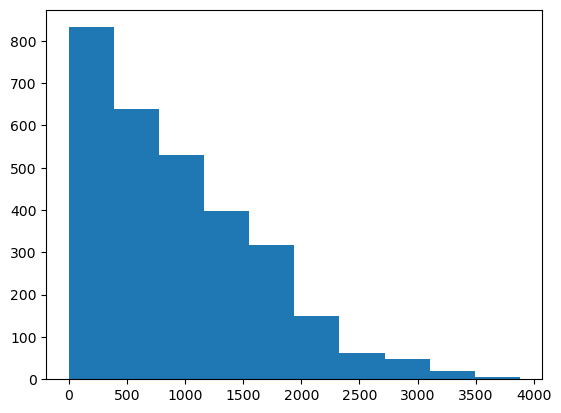

In [66]:
plt.hist(df_bgintersect_5000['5000_MINORPOP_bg_int_count'])

In [63]:
df_bgintersect_5000.head(2)

,bg_id,cnty_name,ACSTOTPOP,MINORPOP,D_PM25_2,bg_area,index_right,BCM_avg,flare_id,flare_cate,5000_buff_int_prop,5000_buff_int_area,5000_buff_tot_area,5000_bg_int_prop,5000_bg_int_area,5000_ACSTOTPOP_bg_int_count,5000_MINORPOP_bg_int_count,MINORPOP_bg_totprop,5000_bg_int_mnr_prop,5000_bcm_int_adj,5000_bcm_int_adj_tot,5000_bcm_int_adj_tot_n,D_PM25_2_n,5000_ACSTOTPOP_bg_int_count_n
0,60133090001,Contra Costa County,1518,922,47.45,"2,295,826.27",89.00,0.01,342ab9d4310483,upstream,0.01,"416,437.32","78,413,712.26",0.18,"416,442.27",275.35,167.24,0.61,0.61,0.00,0.00,-0.18,-0.00,-1.21
1,60133090001,Contra Costa County,1518,922,47.45,"2,295,826.27",90.00,0.01,47291ae3406417,upstream,0.01,"412,831.10","78,413,712.26",0.18,"416,442.27",275.35,167.24,0.61,0.61,0.00,0.00,-0.18,-0.00,-1.21


In [64]:
df_bgintersect_geo5000.to_file('data/df_bg_geo5000.shp', driver='ESRI Shapefile')

/Users/natebender/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


### Combine

In [70]:
# filter the second dataframe to only include columns starting with '5000_' plus the ID columns
# all the non "5000_" columns in the second dataframe are identical to the first df, so can be ignored.
# select columns that start with '5000_' and keep 'bg_id' and 'flare_id'
cols_to_keep = ['bg_id', 'flare_id'] + [col for col in df_bgintersect_5000.columns if col.startswith('5000_')]

In [71]:
cols_to_keep

['bg_id',
 'flare_id',
 '5000_buff_int_prop',
 '5000_buff_int_area',
 '5000_buff_tot_area',
 '5000_bg_int_prop',
 '5000_bg_int_area',
 '5000_ACSTOTPOP_bg_int_count',
 '5000_MINORPOP_bg_int_count',
 '5000_bg_int_mnr_prop',
 '5000_bcm_int_adj',
 '5000_bcm_int_adj_tot',
 '5000_bcm_int_adj_tot_n',
 '5000_ACSTOTPOP_bg_int_count_n']

In [72]:
df_bgintersect_5000_filter = df_bgintersect_5000[cols_to_keep].copy()

In [73]:
df_bgintersect_5000_filter.head(2)

,bg_id,flare_id,5000_buff_int_prop,5000_buff_int_area,5000_buff_tot_area,5000_bg_int_prop,5000_bg_int_area,5000_ACSTOTPOP_bg_int_count,5000_MINORPOP_bg_int_count,5000_bg_int_mnr_prop,5000_bcm_int_adj,5000_bcm_int_adj_tot,5000_bcm_int_adj_tot_n,5000_ACSTOTPOP_bg_int_count_n
0,60133090001,342ab9d4310483,0.01,"416,437.32","78,413,712.26",0.18,"416,442.27",275.35,167.24,0.61,0.00,0.00,-0.18,-1.21
1,60133090001,47291ae3406417,0.01,"412,831.10","78,413,712.26",0.18,"416,442.27",275.35,167.24,0.61,0.00,0.00,-0.18,-1.21


In [85]:


# merge the two dataframes on 'bg_id' and 'flare_id', keeping all columns from the first dataframe
df_bg_intersect_all = pd.merge(df_bgintersect_2000, df_bgintersect_5000_filter, on=['bg_id', 'flare_id'], how='outer')


In [86]:
df_bg_intersect_all.sample(50)

,bg_id,cnty_name,ACSTOTPOP,MINORPOP,D_PM25_2,bg_area,index_right,BCM_avg,flare_id,flare_cate,2000_buff_int_prop,2000_buff_int_area,2000_buff_tot_area,2000_bg_int_prop,2000_bg_int_area,2000_ACSTOTPOP_bg_int_count,2000_MINORPOP_bg_int_count,MINORPOP_bg_totprop,2000_bg_int_mnr_prop,2000_bcm_int_adj,2000_bcm_int_adj_tot,2000_bcm_int_adj_tot_n,D_PM25_2_n,2000_ACSTOTPOP_bg_int_count_n,5000_buff_int_prop,5000_buff_int_area,5000_buff_tot_area,5000_bg_int_prop,5000_bg_int_area,5000_ACSTOTPOP_bg_int_count,5000_MINORPOP_bg_int_count,5000_bg_int_mnr_prop,5000_bcm_int_adj,5000_bcm_int_adj_tot,5000_bcm_int_adj_tot_n,5000_ACSTOTPOP_bg_int_count_n
1638,60375751022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f3188e83798361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,"89,579.17","78,413,712.26",0.37,"89,579.17",685.90,661.26,0.96,0.00,0.00,-0.18,-0.69
611,60133200043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84f8fcac876528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,"560,904.07","78,413,712.26",1.00,"566,934.16","1,198.00",420.00,0.35,0.00,0.00,-0.18,-0.03
41,60133552022,Contra Costa County,"2,148.00","1,870.00",50.32,"19,561,543.93",89.00,0.01,342ab9d4310483,upstream,0.02,"223,925.64","12,546,193.96",0.01,"227,657.03",25.00,21.76,0.87,0.87,0.00,0.00,-0.33,0.22,-0.80,0.19,"14,929,149.64","78,413,712.26",0.81,"15,790,063.09","1,733.86","1,509.46",0.87,0.00,0.02,0.45,0.66
1836,60375765012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caf4a94c957987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,"122,961.77","78,413,712.26",1.00,"122,961.77","1,038.00",541.00,0.52,0.00,0.00,-0.18,-0.24
550,60133141023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47291ae3406417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,"723,490.13","78,413,712.26",1.00,"723,490.13","1,954.00","1,489.00",0.76,0.00,0.00,-0.17,0.94
2719,61110022003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0769b54e140159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,"318,237.38","78,413,712.26",1.00,"318,237.38","1,865.00","1,532.00",0.82,0.00,0.00,-0.14,0.82
2612,61110012041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15d854f9675279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,"194,390.42","78,413,712.26",0.27,"32,108,152.35",751.38,438.46,0.58,0.00,0.10,3.65,-0.60
2769,61110023021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0769b54e140159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,"352,485.68","78,413,712.26",1.00,"352,485.68","1,725.00","1,541.00",0.89,0.00,0.00,-0.13,0.64
1171,60372948301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f3188e83798361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,"75,461.26","78,413,712.26",0.93,"290,052.74","2,928.23","2,884.49",0.99,0.00,0.00,-0.18,2.19
1957,60375779001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34208bde510417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,"11,016.79","78,413,712.26",1.00,"725,225.66","1,108.00",880.00,0.79,0.00,0.00,-0.18,-0.15


In [87]:
len(df_bg_intersect_all)

3002

In [ ]:
df_bg_intersect_all[df_bg_intersect_all['bg_id'].isin([60379800331, 60379800111])]

In [88]:
df_bg_intersect_all.to_csv('data/df_bg_impact_all.tsv', sep='\t', index=False)

# Aggregate by Flare ID and export files for Tableau

Take baseline dfs and create copies clearly defined for this flare buffer analysis, 
separate from the work that is needed for the BG buffer analysis above. 
Both analyses modify these same two dfs in different ways; need to ensure I keep the calculations separated.
Plus, they'll go into Tableau as different dataframes anyway. 

In [ ]:
# Use the baseline df as the starting point

intersect_baseline.sample()

In [ ]:
# Define the variables to aggregate

# BCM_avg: No adjustments needed because bcm is already attached to the flare unit of analysis
# D_PM25_D: Create new var of avg PM25 score for all BGs in each buffer 
# ACSTOTPOP_bg_int_count: Create new var of total population in all intersections in each buffer

agg_dict = {'D_PM25_2': 'mean', 'ACSTOTPOP_bg_int_count': 'sum'}

# set up df for flare-specific calcs
flare_intersect = intersect_baseline.copy()

# Group the block groups by flare ID and aggregrate the selected vars
flare_agg = intersect_baseline.groupby('flare_id').agg(agg_dict)

# Rename the output variables
flare_agg = flare_agg.rename(columns={'D_PM25_2': 'int_pm25_avg', 'ACSTOTPOP_bg_int_count': 'int_pop_sum'})

# Join the aggregated variables with the original columns
flare_intersect = flare_intersect.merge(flare_agg, on='flare_id')


In [ ]:
flare_intersect.sample(1)

In [ ]:
# Define the variables to standardize

varlist = ['BCM_avg', 'int_pm25_avg', 'int_pop_sum']  

# Create a StandardScaler object that will transform selected variables to have a mean of zero and 
# sd of 1.
scaler = StandardScaler()

# Fit and transform the selected variables
intersect_norm = scaler.fit_transform(flare_intersect[varlist])

# Create new variables with the standardized values
intersect_norm = pd.DataFrame(intersect_norm, columns=[var + '_n' for var in varlist])

# Concatenate the new variables with the original DataFrame
flare_intersect = pd.concat([flare_intersect, intersect_norm], axis=1)

In [ ]:
type(flare_intersect)

In [ ]:
flare_intersect.sample(3)

In [ ]:
# Create a new geodataframe with just the id and geom columns
# flare_intersect_geo = flare_intersect[['flare_id', 'buff2000_geom']].copy()
flare_intersect_geo = gp.GeoDataFrame(flare_intersect[['bg_id', 'bg_int_geom']].copy(), 
                                      geometry='bg_int_geom', crs=meters_crs)


# Subset the original dataframe and drop unnecessary columns
flare_intersect = flare_intersect.drop(['bg_geom', 'bg_int_geom', 'buff2000_geom'], axis=1)

In [ ]:
type(flare_intersect_geo)

In [ ]:
flare_intersect.sample(1)

In [ ]:
flare_intersect_geo.sample(1)

In [ ]:
flare_intersect.to_csv('data/df_flareimp_all.tsv', sep='\t', index=False)

In [ ]:
flare_intersect_geo.to_file("data/df_flareimp_geo.shp", driver='ESRI Shapefile')

## Calculating single instance of weights here in python

In [ ]:
# # Define the weights for each variable
# bcm_weight = 0
# pm25_weight = 1
# pop_weight = 0

In [ ]:
# # Calculate the weighted variables
# intersect['BCM_weighted'] = intersect['BCM_avg_norm'] * bcm_weight
# intersect['D_PM25_2_weighted'] = intersect['D_PM25_2_norm'] * pm25_weight
# intersect['ACSTOTPOP_weighted'] = intersect['ACSTOTPOP_intersect_count_norm'] * pop_weight

# # Define the variables to sum
# varlist_weighted = ['BCM_weighted', 'D_PM25_2_weighted', 'ACSTOTPOP_weighted']

# # Group the block groups by flare ID and sum the weighted variables
# ca_flares_merged = intersect.groupby('flare_id')[varlist_weighted].sum()

# # Calculate the impact metric as the sum of the weighted variables
# ca_flares_merged['impact_metric'] = ca_flares_merged[varlist_weighted].sum(axis=1)

# # Sort the flares by impact metric in descending order
# ca_flares_merged = ca_flares_merged.sort_values('impact_metric', ascending=False)

In [ ]:
# # Show the results
# ca_flares_merged.head()

In [ ]:
# # Define the variables to sum
# varlist_norm = ['BCM_avg_norm', 'D_PM25_2_norm', 'ACSTOTPOP_intersect_count_norm']

# # Group the block groups by flare ID and sum the standardized variables
# ca_flares_merged = intersect.groupby('flare_id')[varlist_norm].sum()

# # Calculate the impact metric as the sum of the standardized variables
# ca_flares_merged['impact_metric'] = ca_flares_merged[varlist_norm].sum(axis=1)

# # Sort the flares by impact metric in descending order
# ca_flares_merged = ca_flares_merged.sort_values('impact_metric', ascending=False)

In [ ]:
# df_final = pd.merge(ca_flares_merged, intersect, on='flare_id')

In [ ]:
# invalid_geoms = df_final[~df_final.is_valid]

In [ ]:
# invalid_geoms

In [ ]:
# # save for use in tableau
# df_final.to_csv(F"data/df_impactmetric_csv.csv", index=False)

In [ ]:
# # check for missing values
# missing_values = df_final.isnull().sum()

# # filter columns with missing values
# missing_cols = missing_values[missing_values > 0]

# # print column names and number of missing values
# for col in missing_cols.index:
#     print(f"Column '{col}' has {missing_cols[col]} missing values")

In [ ]:
# no_missing = missing_values[missing_values == 0]
# # print column names and number of missing values
# for col in no_missing.index:
#     print(f"Column '{col}' has {no_missing[col]} missing values")

In [ ]:
# df_final.sample(2)

## Top ten

In [ ]:
# # display the top ten flares by impact metric
# top_ten = for_map.nlargest(10, 'impact_metric')
# top_ten = top_ten.set_geometry('buffer_2000m')

In [ ]:
# # check for missing values
# missing_values = for_map.isnull().sum()

# # filter columns with missing values
# missing_cols = missing_values[missing_values > 0]

# # print column names and number of missing values
# for col in missing_cols.index:
#     print(f"Column '{col}' has {missing_cols[col]} missing values")

In [ ]:
# no_missing = missing_values[missing_values == 0]
# # print column names and number of missing values
# for col in no_missing.index:
#     print(f"Column '{col}' has {no_missing[col]} missing values")

## Folium Mapping

In [ ]:
# for_map = df_final[['flare_id', 'BCM_avg', 'D_PM25_2', 'ACSTOTPOP_intersect_count', 'impact_metric', 'buffer_2000m']]
# for_map = gp.GeoDataFrame(for_map, geometry='buffer_2000m', crs=meters_crs)

# for_map.to_file("data/df_impactmetric_shp.shp", driver='ESRI Shapefile')

In [ ]:

# # Define the color scale and number of bins
# #color_scale = 'Reds'
# #num_bins = 10

# # Create a map centered on the first flare
# # Create a folium map with a center location
# m = folium.Map(location=[38.377158,-121.645792], zoom_start=6, tiles=None,overlay=False)  #start w lat/long roughly in center of CA
# base_map = folium.FeatureGroup(name='Base map', overlay=True, control=False)
# folium.TileLayer(tiles='OpenStreetMap').add_to(base_map)
# base_map.add_to(m)




In [ ]:
# # Feature Group: Buffers

# def style_function3(feature):
#     return {
#         'fillColor': 'red',
#         'color': 'red',
#         'fillOpacity': 0.05
#     }

# inter_all_bg = folium.FeatureGroup(name='Intersect BG', overlay=True)
# folium.GeoJson(
#     data=test["buffer_2000m"],
#     style_function=style_function3
# ).add_to(inter_all_bg)
# inter_all_bg.add_to(m)

In [ ]:
# # Feature Group: block group

# def style_function2(feature):
#     return {
#         'fillColor': 'blue',
#         'color': 'blue',
#         'fillOpacity': 0.05
#     }

# bg_bound = folium.FeatureGroup(name='Intersect BG', overlay=True)
# folium.GeoJson(
#     data=test["bg_geom"],
#     style_function=style_function2
# ).add_to(bg_bound)
# bg_bound.add_to(m)

In [ ]:
# style_function = lambda x: {'fillColor': '#ffffff', 
#                             'color':'#000000', 
#                             'fillOpacity': 0.1, 
#                             'weight': 0.1}
# highlight_function = lambda x: {'fillColor': '#999999', 
#                                 'color':'#999999', 
#                                 'fillOpacity': 0.50, 
#                                 'weight': 0.1}
# NIL = folium.features.GeoJson(
#     data = for_map,
#     style_function=style_function, 
#     control=False,
#     highlight_function=highlight_function, 
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['flare_id', 'BCM_avg_norm', 'D_PM25_2_norm', 
#              'ACSTOTPOP_intersect_count_norm', 'impact_metric'],# 'D_PM25_2', 'ACSTOTPOP', 'MINORPOP','shape_area_new', 'intersect_prop', 'intersect_area', 'MINORPOP_bg_totprop'],
#         style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
#     )
# )

In [ ]:
# # add hover functionality as child to map, add layering, display map
# m.add_child(NIL)
# m.keep_in_front(NIL)
# folium.LayerControl().add_to(m)

In [ ]:
# # Display the map
# m